# GitHub timeline

## GraphQL API

In [13]:
import requests, os
from dotenv import load_dotenv
load_dotenv()

# 1) Personal access token from GitHub
TOKEN = os.getenv('GITHUB_API_TOKEN')

# 2) GraphQL endpoint
GITHUB_GRAPHQL_URL = "https://api.github.com/graphql"

# 3) Prepare headers
headers = {
    "Authorization": f"Bearer {TOKEN}",  # NOTE: 'Bearer' not 'token'
    "Content-Type": "application/json"
}

# 4) Example GraphQL query
# In this sample, we'll request:
#   - The user's name and login
#   - A snippet of their public repositories
#   - (Any additional fields you'd like)
query = """
query($userLogin: String!) {
  user(login: $userLogin) {
    name
    login
    url
    repositories(first: 3, orderBy: {field: CREATED_AT, direction: DESC}) {
      edges {
        node {
          name
          createdAt
          url
        }
      }
    }
  }
}
"""

# 5) Variables for that query
variables = {"userLogin": "yanndebray"}

# 6) Make the request
resp = requests.post(
    GITHUB_GRAPHQL_URL,
    headers=headers,
    json={"query": query, "variables": variables},
)

# 7) Parse the JSON response
data = resp.json()

# 8) Inspect the result
if "errors" in data:
    print("Errors returned by the API:", data["errors"])
else:
    user_info = data["data"]["user"]
    print("User info:", user_info)


User info: {'name': 'Yann Debray', 'login': 'yanndebray', 'url': 'https://github.com/yanndebray', 'repositories': {'edges': [{'node': {'name': 'github-api', 'createdAt': '2025-02-02T21:15:36Z', 'url': 'https://github.com/yanndebray/github-api'}}, {'node': {'name': 'python-training', 'createdAt': '2025-01-20T22:12:49Z', 'url': 'https://github.com/yanndebray/python-training'}}, {'node': {'name': 'sbw-live-coding', 'createdAt': '2025-01-13T17:02:30Z', 'url': 'https://github.com/rpelissier/sbw-live-coding'}}]}}


## Python API

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from github import Github
from collections import Counter

In [2]:
g = Github()

user = g.get_user("yanndebray")

# We’ll look back 365 days from now
today = datetime.datetime.utcnow()
one_year_ago = (today - datetime.timedelta(days=365)).replace(tzinfo=datetime.timezone.utc)

# Count how many events occurred on each day
day_counts = Counter()

# get_events() returns the 30 most recent public events, then you can paginate further if needed
events = user.get_events()
for event in events:
    event_date = event.created_at
    if event_date >= one_year_ago:
        # We only care about the YYYY-MM-DD portion
        day_str = event_date.strftime("%Y-%m-%d")
        day_counts[day_str] += 1

# day_counts now maps e.g. "2024-05-23" -> <count of events on that day>


In [3]:

one_year_ago = datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=365)

all_events = []
events = user.get_events()  # This returns a PaginatedList
page = 0

while True:
    page_events = events.get_page(page)
    if not page_events:
        break

    for e in page_events:
        # Stop if we've gone beyond one year
        if e.created_at < one_year_ago:
            break
        all_events.append(e)

    page += 1

print(f"Fetched {len(all_events)} events (likely covering ~90 days).")

Fetched 13 events (likely covering ~90 days).


In [4]:
# We’ll build an array of shape (7 rows, 53 columns) full of zeros
heatmap = np.zeros((7, 53), dtype=int)

# The leftmost column is the earliest Monday in our range, so find the Monday before (or on) one_year_ago:
start_date = one_year_ago
# Shift back to the most recent Monday (so we align weeks in columns).
while start_date.weekday() != 0:  # Monday is weekday() == 0
    start_date -= datetime.timedelta(days=1)

# Make today timezone-aware
today = today.replace(tzinfo=datetime.timezone.utc)

# Fill the heatmap
current_date = start_date
for col in range(53):
    for row in range(7):
        date_str = current_date.strftime("%Y-%m-%d")
        # Use our counter; default to 0 if not in the Counter
        heatmap[row, col] = day_counts[date_str]
        current_date += datetime.timedelta(days=1)

        # If we pass today, we can stop
        if current_date > today:
            break
    if current_date > today:
        break

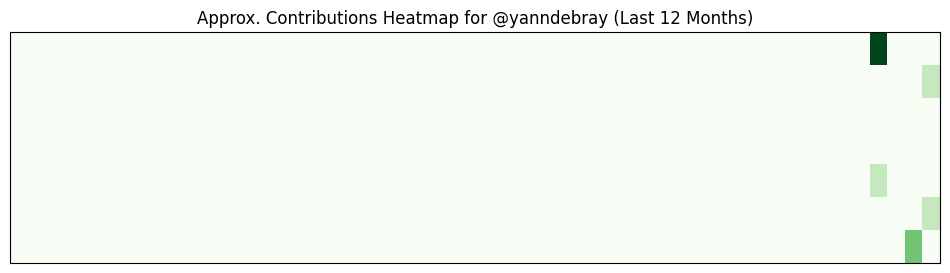

In [5]:
fig, ax = plt.subplots(figsize=(12, 3))

# We flip the rows so that row=0 is Monday at the top.
# If you prefer Sunday at top, reorder accordingly.
ax.imshow(
    np.flipud(heatmap), 
    cmap="Greens",       # GitHub-like green colormap
    aspect="auto",
    interpolation="nearest"
)

ax.set_title("Approx. Contributions Heatmap for @yanndebray (Last 12 Months)")
ax.set_xticks([])
ax.set_yticks([])

plt.show()
